# Wetland Inundation and Vegetation Dynamics

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a), 
[wofs_ls](https://explorer.digitalearth.africa/wofs_ls),

* **Prerequisites:** Water extent, 


## Background

> *This notebook is being developed to support the use case below.
It will be progressively updated.*

Analyzing Effects of the 2019 Drought on Inundation Extent and Vegetation Cover Dynamics in the Okavango Delta.

To assess the effect of 2019 drought on inundation extent and vegetation cover types in the Okavango Delta: with main emphasis on floodplain vegetation, riparian woodland, and dryland vegetation.
The results of the use case will contribute to development of large-scale low inundation extent map products and provide recent baseline maps on vegetation cover types of dynamics in the Okavango Delta system at a landscape approach, which are essential elements for integrated wetland and climate risks management by relevant decision makers.

https://user-images.githubusercontent.com/9433467/117004838-1037c000-acd6-11eb-8fe9-557c49376bd0.png

Input data:

Okavango delta Vector file
Sentinel Data: May - September 2019
Water Observation from Space: May - September 2019
Expected outcomes and outputs:

The 2019 low flood extent Map (May to September). This will provide a basis for high spatial resolution Earth Observation Derived information on the effects of drought stress in the Okavango Delta wetland water extent, which is essential for improved environmental and climate risks management by decision makers
land cover classification for water, aquatic vegetation, primary floodplains, secondary floodplains, grassland, riparian vegetation, dry grassland/saltpan, dry woodland. May to September or extend to Apr - Oct/Nov.
**Additional information: **

McCarthy, J. Gumbricht, T. & McCarthy, T.S. (2005). Ecoregion classification in the Okavango Delta, Botswana from multitemporal remote sensing. International Journal of Remote Sensing 26 (19): 4339–4357.

## Description

We will break down the analysis into a few steps:

1. Select a small area to develop the method
2. Map water extent using S2 and LS (WOfS)
3. Map different land covers
4. TBA

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.


In [1]:
#need to run this before Cape Town transition
#!pip install -e ../Tools

In [2]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from datacube.storage import masking

from deafrica_tools.datahandling import load_ard, wofs_fuser, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb, xr_animation
from deafrica_tools.dask import create_local_dask_cluster

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='Okavango')

### Analysis parameters

Setting the parameters and restriciting to a small area to test time-series methods.

The parameters are:

* `lat`: The central latitude to analyse (e.g. 10.338).
* `lon` : The central longitude to analyse (e.g. -1.055).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.

In [4]:
# Define the area of interest
lat = -19.
lon = 22.5

lat_buffer = 0.05
lon_buffer = 0.05

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

In [5]:
display_map(lon_range, lat_range)

### Create a query with location, time and set up output CRS

The output CRS is selected to be the most common UTM. This may or may not work well if the area is across UTM zones.

In [6]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'dask_chunks':{'time':1,'x':1000,'y':1000}
}

output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)
print(output_crs)

query['output_crs'] = output_crs

epsg:32734


### Water extent and changes detected by WOfS

In [7]:
# Load WOfS
wofls = dc.load(product=["ga_ls8c_wofs_2"],
                time=('2018', '2019-06'), # Current WOfS coverage
                resolution=(-30, 30),
                fuse_func=wofs_fuser,
                group_by='solar_day',
                **query
                )

In [8]:
# caculate wofs frequency

nwet = masking.make_mask(wofls.water, wet=True).resample(time='3MS').sum(dim='time').compute()
ndry = masking.make_mask(wofls.water, dry=True).resample(time='3MS').sum(dim='time').compute()
freq = nwet/(nwet+ndry)

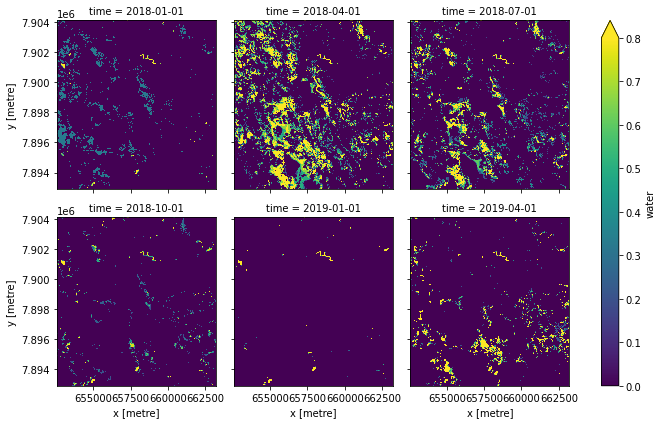

In [9]:
freq.plot.imshow(robust=True, col='time', col_wrap=3);

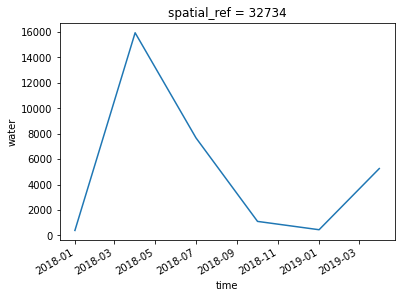

In [10]:
# water extent defined as detected >50% of time
(freq>0.5).sum(dim=['x','y']).plot();

### Water extent and changes detected by S2

In [11]:
# load Sentinel-2 data
ds_s2 = load_ard(dc=dc,
                 products=['s2_l2a'], resolution=(-10, 10),
                 time=('2018', '2019'),
                 measurements=['blue', 'green', 'red',
                               'nir', 'swir_1', 'swir_2'],
                 min_gooddata=0.75,
                 group_by='solar_day',
                 **query)

/home/jovyan/dev/deafrica-sandbox-notebooks/Tools/deafrica_tools/datahandling.py:244: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  "Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 118 out of 145 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Returning 118 time steps as a dask array


In [12]:
s2_indices = calculate_indices(ds_s2,index=['MNDWI', 'TCW' ,'WI'], normalise=True, collection='s2', drop=True).compute()

Dropping bands ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2']


In [13]:
#s2_indices.WI.plot.hist(bins=100);

In [14]:
#s2_indices.TCW.plot.hist(bins=100);

In [15]:
# frequency calculated using WI
freq_s2_wi = (s2_indices.WI>0.65).resample(time='3MS').mean(dim='time').compute()

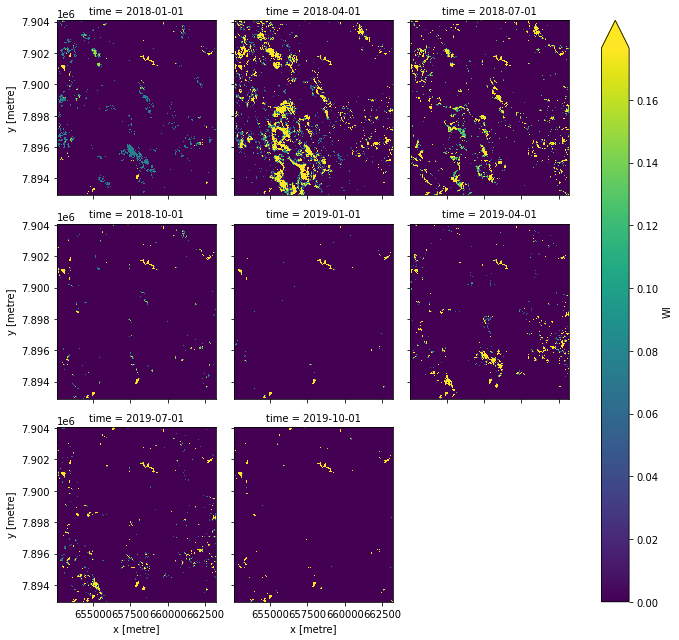

In [18]:
# water frequency
freq_s2_wi.plot.imshow(robust=True, col='time', col_wrap=3);

In [25]:
# frequency calculated using TCW, the result is very senstive to the threshold
# I think the recommended threhold is 0.01, which doesn't give much water in this case
freq_s2_tcw = (s2_indices.TCW>-0.01).resample(time='3MS').mean(dim='time').compute()

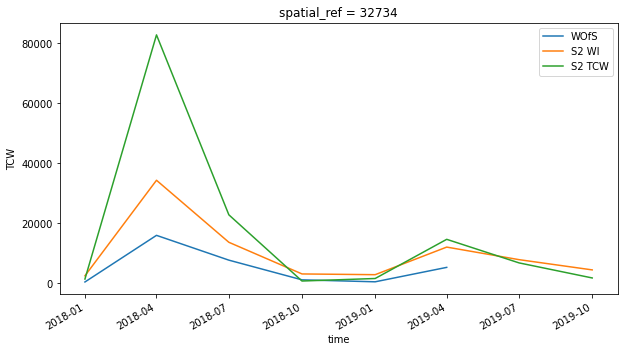

In [30]:
(freq>0.5).sum(dim=['x','y']).plot(label='WOfS', figsize=(10,5));
(freq_s2_wi>0.5).sum(dim=['x','y']).plot(label='S2 WI');
(freq_s2_tcw>0.5).sum(dim=['x','y']).plot(label='S2 TCW');

plt.legend();

All datasets show peak water extent in 2019 is much smaller than 2018.

WOfS is designed to only detect open water and the 30 m resolution means narrow channels are not detected.

The indices used for Sentinel-2 were developed for Landsat and thresholds are selected based on study in Australia. Qualitatively results from S2 agree with WOfS. Bigger extents detected by S2 can be due to high resolution.

Sentinel-2 results are sensitive to thresholds chosen. A somewhat arbitary threshold is used for TCW.


## Vegetation and Land cover dynamics

A few things can be tried:
1. Rule-based classification: water, wet-veg, green, non-green, bare
2. Supervised classification; requires reference data, which may be collected through CEO
3. Unsupervised clustering using GeoMAD.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')